In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import cv2
from scipy.fft import fft, ifft, fft2, fftshift
from scipy.signal import windows
import numpy as np
from skimage import img_as_float

In [2]:
def showimage(img):
    plt.imshow(img, cmap="Greys_r")
    plt.show()

In [7]:
img = cv2.imread("images/baboon.png", cv2.IMREAD_GRAYSCALE)

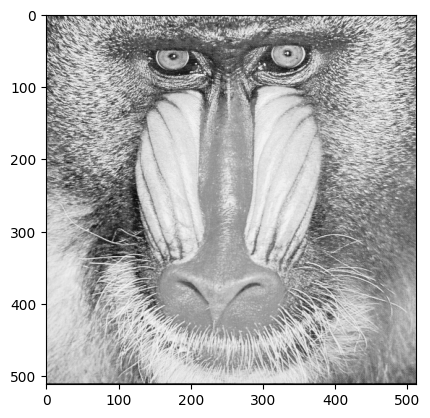

In [8]:
showimage(img)

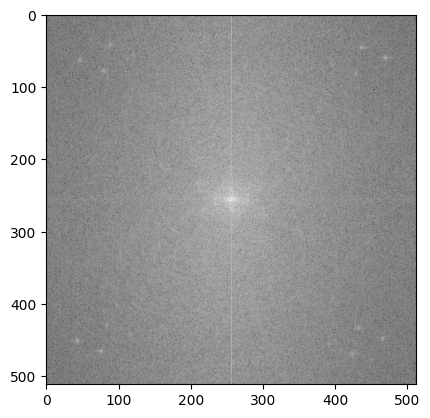

In [69]:
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
# Compute the discrete Fourier Transform of the image
fourier = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
 
# Shift the zero-frequency component to the center of the spectrum
fourier_shift = np.fft.fftshift(fourier)
magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
showimage(magnitude)

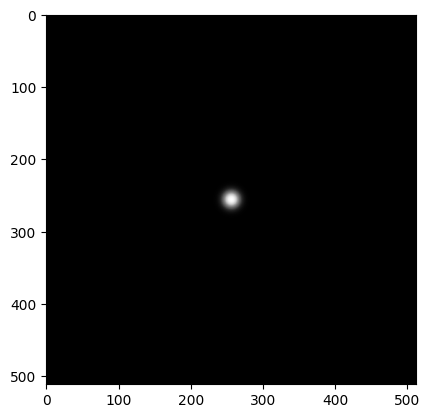

In [116]:
r = 500 # how narrower the window is
ham = np.hamming(img.shape[0])[:,None] # 1D hamming
ham = windows.hamming(img.shape[0], )[:, None]
ham = windows.get_window("hamming", img.shape[0])[:, None]
ham2d = np.sqrt(np.dot(ham, ham.T)) ** r
showimage(ham2d)

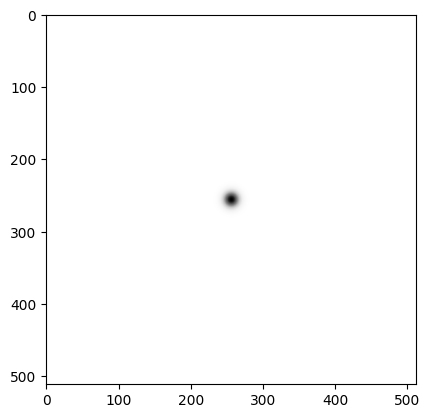

In [155]:
showimage(255-ham2d)

In [118]:
f_complex = fourier_shift[:,:,0]*1j + fourier_shift[:,:,1]
f_filtered = ham2d * f_complex

f_filtered_shifted = np.fft.fftshift(f_filtered)
inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
filtered_img = np.abs(inv_img)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

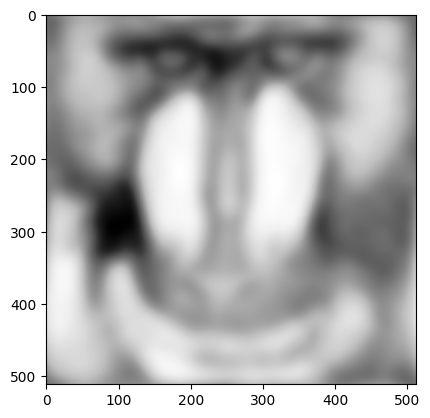

In [119]:
showimage(filtered_img)

In [152]:
def apply_freq_filter(img, window_filter, window_r, high=False):
    fourier = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
 
    # Shift the zero-frequency component to the center of the spectrum
    fourier_shift = np.fft.fftshift(fourier)
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    window_filter = windows.get_window(window_filter, img.shape[0])[:, None]
    window_filter2d = np.sqrt(np.dot(window_filter, window_filter.T)) ** window_r
    if high:
        window_filter2d = 255 - window_filter2d

    f_complex = fourier_shift[:,:,0]*1j + fourier_shift[:,:,1]
    f_filtered = window_filter2d * f_complex
    
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)

    return filtered_img, magnitude, magnitude * window_filter2d

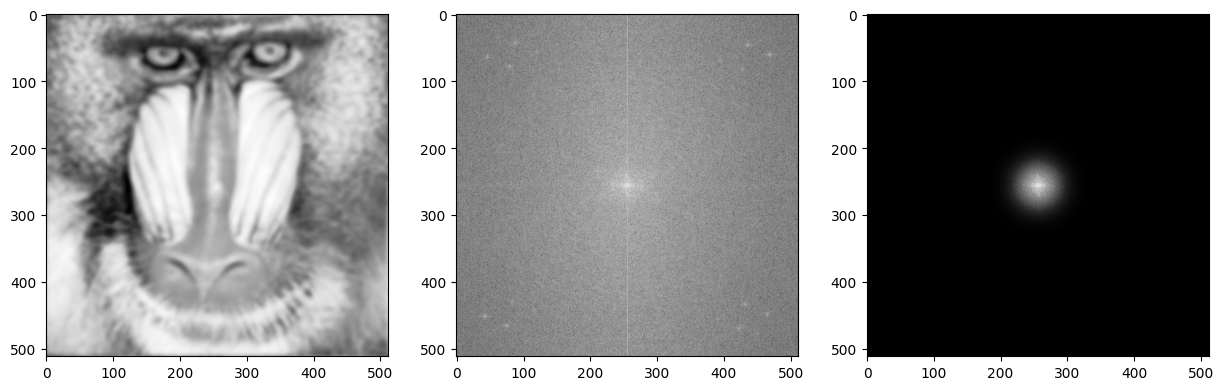

In [137]:
filtered, mag, core = apply_freq_filter(img, "hamming", 50)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

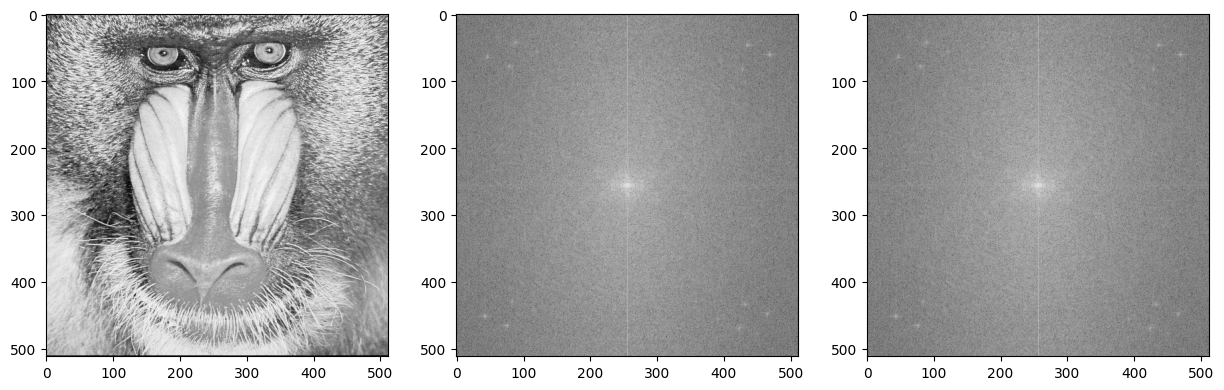

In [153]:
filtered, mag, core = apply_freq_filter(img, "hamming", 50, True)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

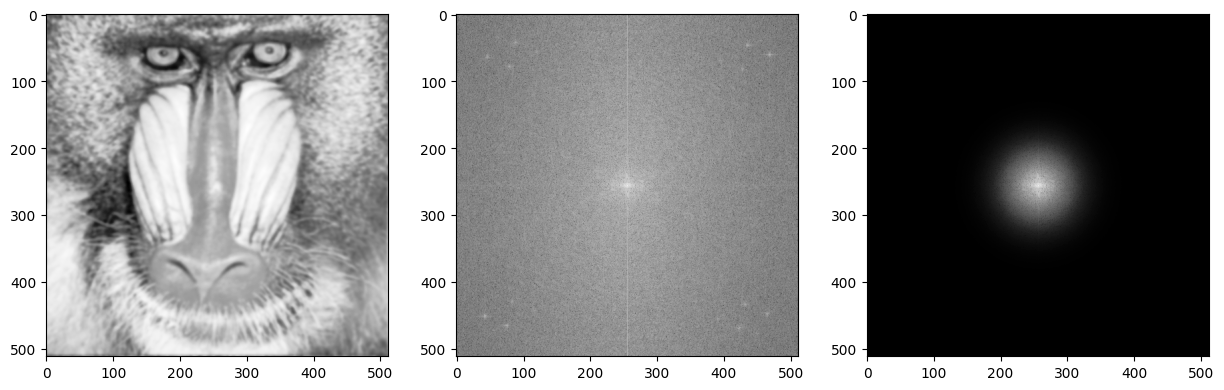

In [145]:
filtered, mag, core = apply_freq_filter(img, ("gaussian", 200), 50)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

In [263]:
def apply_freq_filter2(img, r1, r2 = None, high=False, reject=False):
    if r2 is not None:
        assert r2 > r1, "r2 deve ser maior que r1"

    dft = np.fft.fft2(img, axes=(0,1))
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    spec = np.log2(mag)
    spec = cv2.normalize(spec, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # magnitude = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    # magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    mask = np.zeros_like(img)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    cv2.circle(mask, (cx,cy), r1, (255,255,255), -1)[0] 
    if r2 is not None:
        core1 = (255,255,255) if reject else (0,0,0)
        core2 = (0,0,0) if reject else (255,255,255)
        
        cv2.circle(mask, (cx,cy), r2, core2, -1)[0]
        cv2.circle(mask, (cx,cy), r1, core1, -1)[0]
           
    if high:
        mask =  255 - mask
    dft_shift_masked = np.multiply(dft_shift,mask) / 255    
    
    back_ishift = np.fft.ifftshift(dft_shift)
    back_ishift_masked = np.fft.ifftshift(dft_shift_masked)

    img_back = np.fft.ifft2(back_ishift, axes=(0,1))
    img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))

    img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
    img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    return img_filtered, spec, (mask * spec)#, img_back

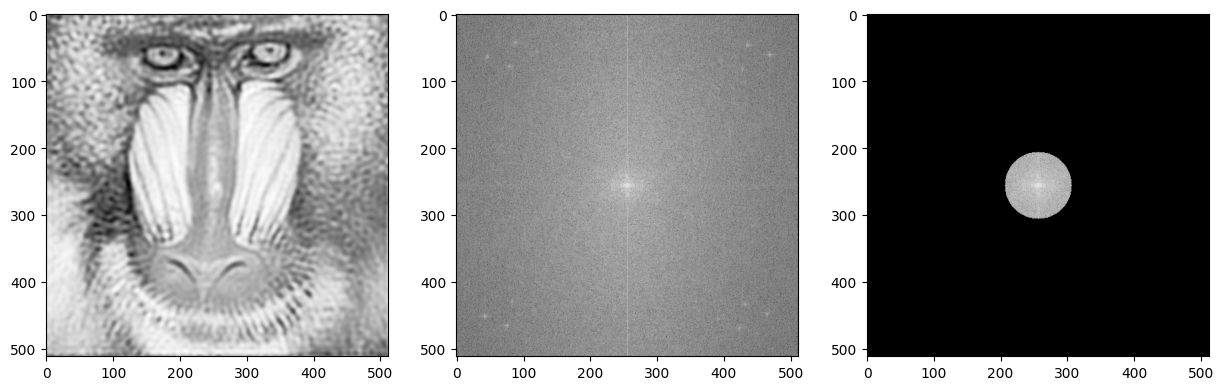

In [261]:
filtered, mag, core = apply_freq_filter2(img, 50)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

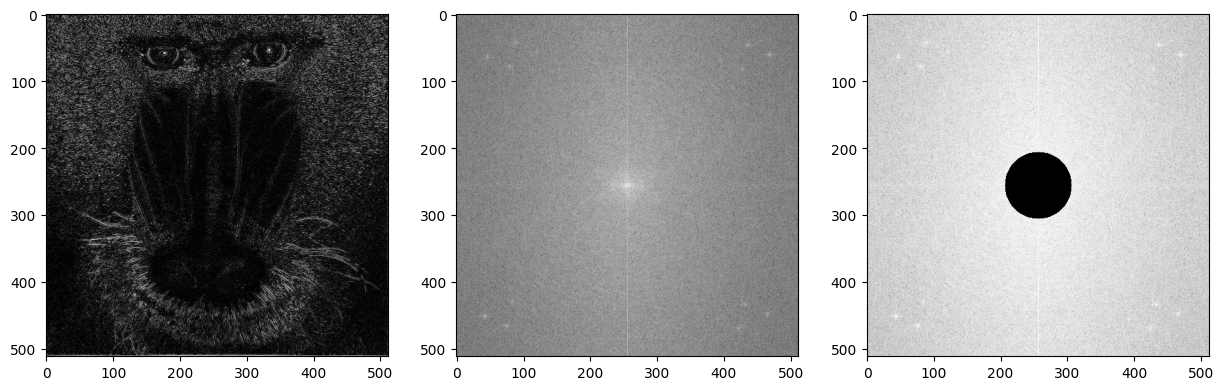

In [264]:
filtered, mag, core = apply_freq_filter2(img, 50, high=True)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

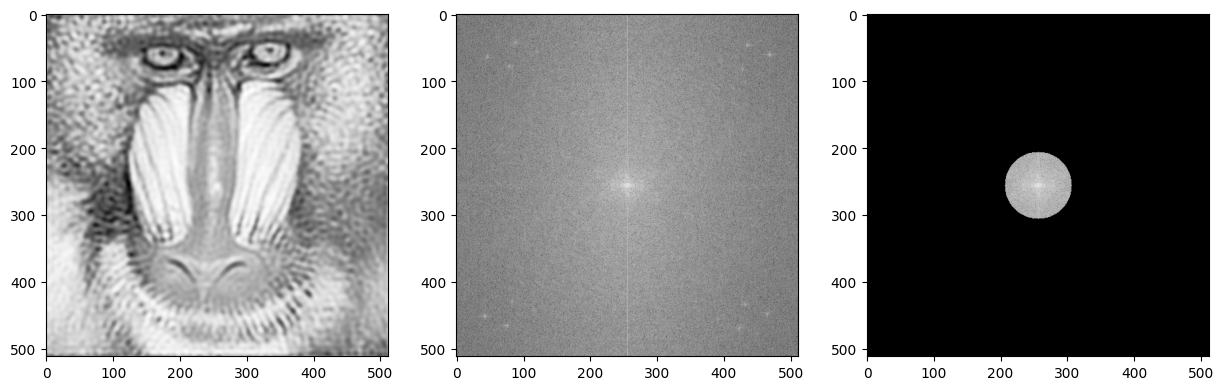

In [221]:
filtered, mag, core = apply_freq_filter2(img, 50,)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

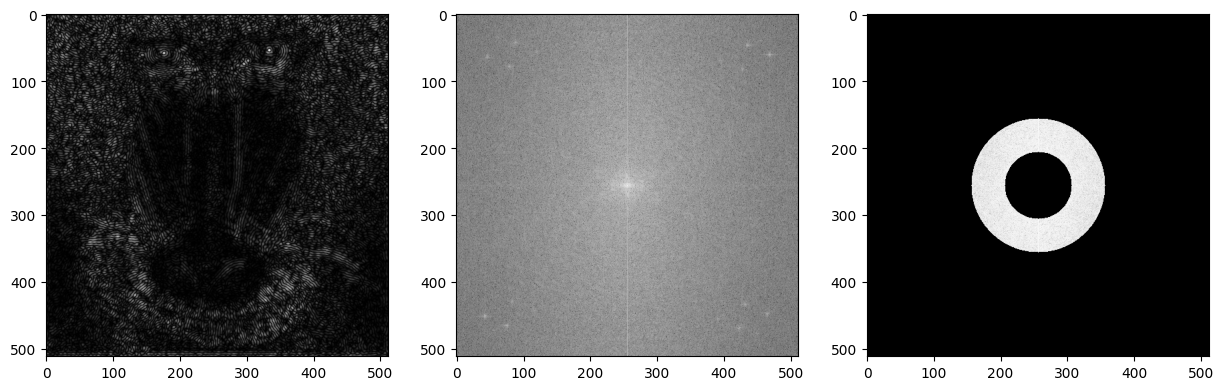

In [215]:
filtered, mag, core = apply_freq_filter2(img, 50, 100)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

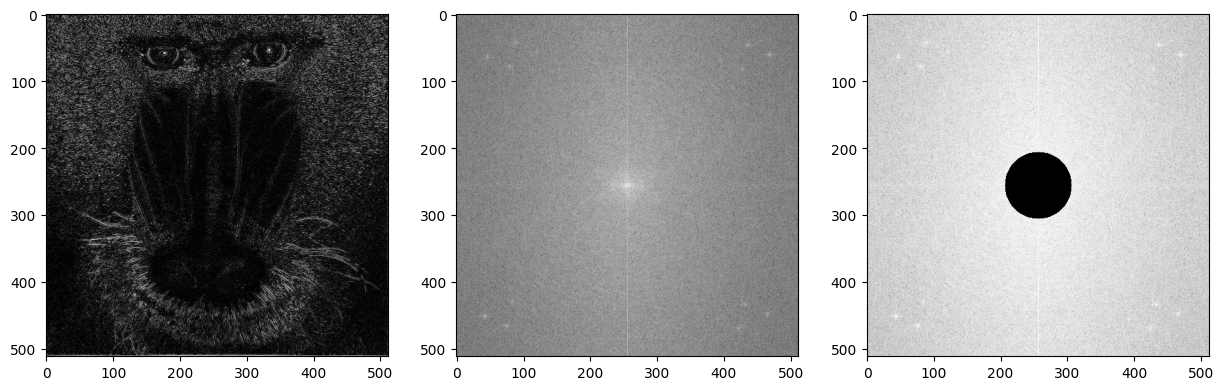

In [217]:
filtered, mag, core = apply_freq_filter2(img, 50, 100, high=True, reject=True)
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[1].imshow(mag, cmap="Greys_r")
ax[2].imshow(core, cmap="Greys_r")

In [34]:
def apply_freq_filter3(img, r1, r2 = None, high=False, reject=False, t=60):
    if r2 is not None:
        assert r2 > r1, "r2 deve ser maior que r1"
    fourier = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
 
    fourier_shift = np.fft.fftshift(fourier)
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    mask = np.zeros_like(img)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    cv2.circle(mask, (cx,cy), r1, (255,255,255), -1)[0] 
    if r2 is not None:        
        cv2.circle(mask, (cx,cy), r2, (255,255,255), -1)[0]
        cv2.circle(mask, (cx,cy), r1, (0,0,0), -1)[0]
           
    if high:
        mask =  255 - mask
    if reject:
        mask = np.where(mask == 255, 0, 255)

    f_complex = fourier_shift[:,:,0]*1j + fourier_shift[:,:,1]
    f_filtered = mask * f_complex
    
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img*255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)

    f_orig_shifted = np.fft.fftshift(np.where(magnitude < t, 0, f_complex))
    inv_orig_img = np.fft.ifft2(f_orig_shifted) # inverse F.T.
    back_img = np.abs(inv_orig_img)
    back_img -= back_img.min()
    back_img = back_img*255 / back_img.max()
    back_img = back_img.astype(np.uint8)

    return filtered_img, magnitude, (magnitude * (mask/255)).astype(np.uint8), back_img

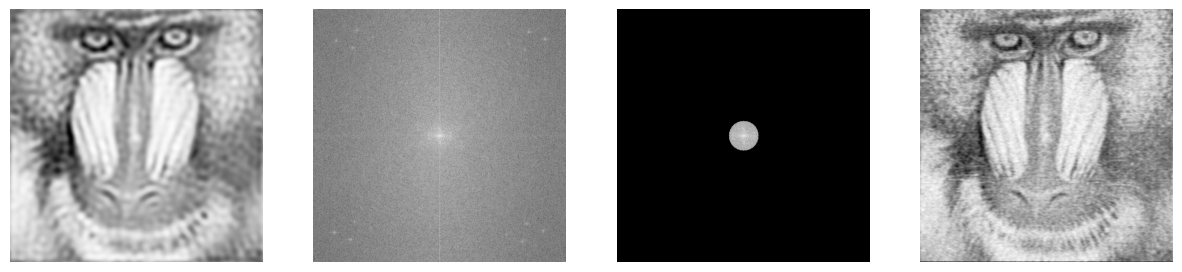

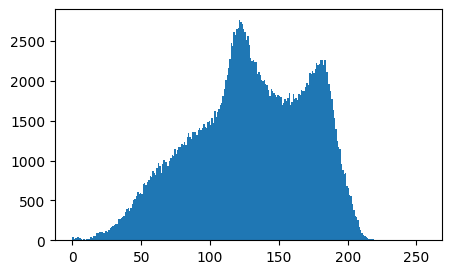

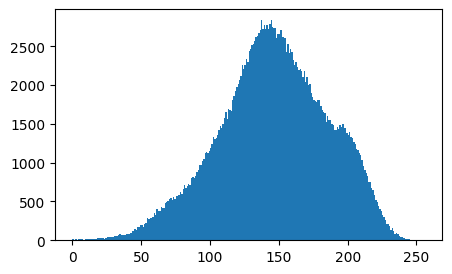

In [95]:
img_path = "images/baboon.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

r1=30; r2 = None; high=False; reject=False; t=150
filtered, mag, core, back = apply_freq_filter3(img, r1, r2, high, reject, t)

fig, ax = plt.subplots(ncols=4, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[0].axis("off")
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
filter_type = "passa_alta" if high else "passa_baixa"
if r2 is not None: filter_type = "passa_faixa"
if r2 is not None and reject: filter_type = "rejeita_faixa"
radius = f"r1={r1}" if r2 is None else f"r1={r1}-r2{r2}"
file_path = f"{img_path.split('.png')[0]}-{filter_type}-{radius}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

ax[1].imshow(mag, cmap="Greys_r")
ax[1].axis("off")
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-espectro.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[2].imshow(core, cmap="Greys_r")
ax[2].axis("off")
extent = ax[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-núcleo-{filter_type}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[3].imshow(back, cmap="Greys_r")
ax[3].axis("off")
extent = ax[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-compressed-threshold={t}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

fig, ax = plt.subplots(figsize=(5,3))

hist_orig = ax.hist(img.ravel(), 256, [0,256])
# ax[0].title.set_text("Histograma imagem original.")
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_originalHistogram.png",
            bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))

hist_comp = ax.hist(back.ravel(), 256, [0,256])
# ax[1].title.set_text("Histograma imagem comprimida.")
# extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_compressedHistogram-threshold={t}.png",
            bbox_inches='tight')

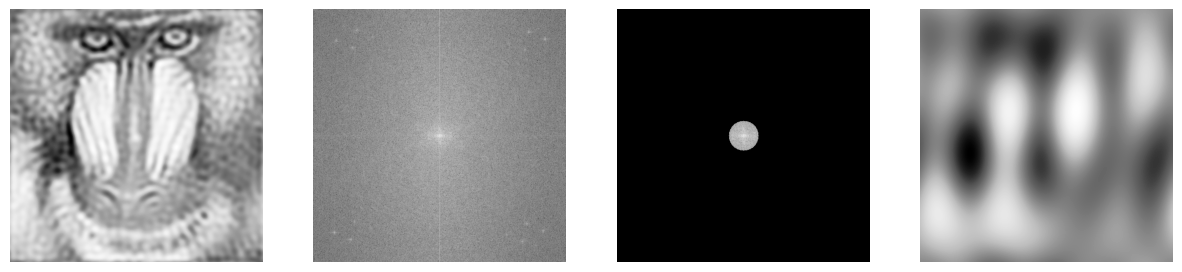

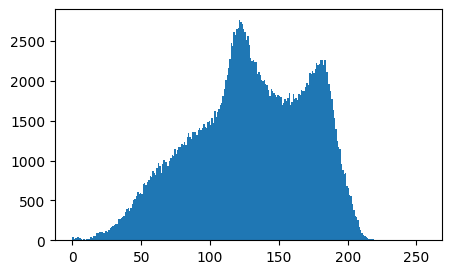

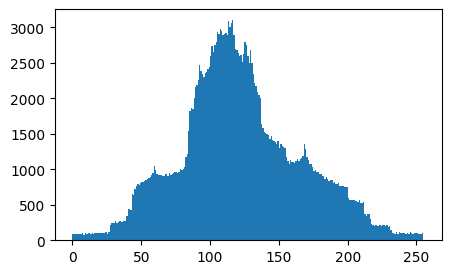

In [96]:
img_path = "images/baboon.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

r1=30; r2 = None; high=False; reject=False; t=200
filtered, mag, core, back = apply_freq_filter3(img, r1, r2, high, reject, t)

fig, ax = plt.subplots(ncols=4, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[0].axis("off")
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
filter_type = "passa_alta" if high else "passa_baixa"
if r2 is not None: filter_type = "passa_faixa"
if r2 is not None and reject: filter_type = "rejeita_faixa"
radius = f"r1={r1}" if r2 is None else f"r1={r1}-r2{r2}"
file_path = f"{img_path.split('.png')[0]}-{filter_type}-{radius}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

ax[1].imshow(mag, cmap="Greys_r")
ax[1].axis("off")
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-espectro.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[2].imshow(core, cmap="Greys_r")
ax[2].axis("off")
extent = ax[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-núcleo-{filter_type}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[3].imshow(back, cmap="Greys_r")
ax[3].axis("off")
extent = ax[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-compressed-threshold={t}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

fig, ax = plt.subplots(figsize=(5,3))

hist_orig = ax.hist(img.ravel(), 256, [0,256])
# ax[0].title.set_text("Histograma imagem original.")
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_originalHistogram.png",
            bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))

hist_comp = ax.hist(back.ravel(), 256, [0,256])
# ax[1].title.set_text("Histograma imagem comprimida.")
# extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_compressedHistogram-threshold={t}.png",
            bbox_inches='tight')

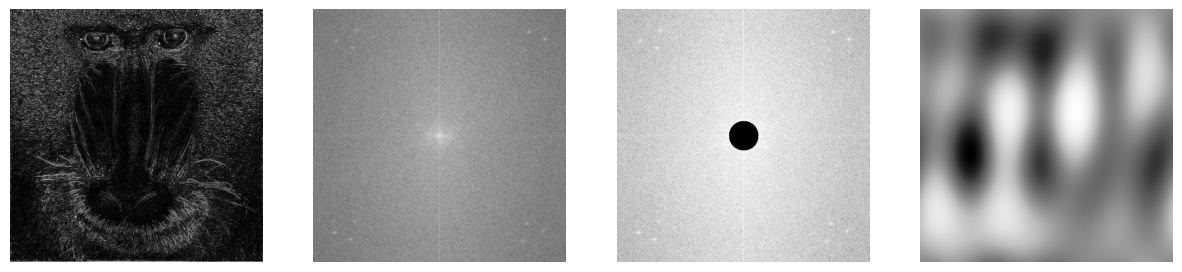

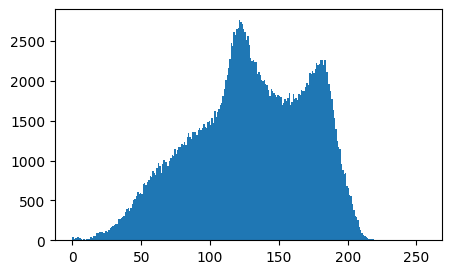

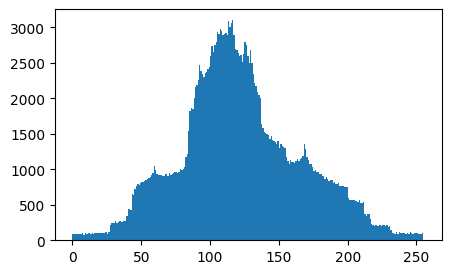

In [97]:
img_path = "images/baboon.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

r1=30; r2 = None; high=True; reject=False; t=200
filtered, mag, core, back = apply_freq_filter3(img, r1, r2, high, reject, t)

fig, ax = plt.subplots(ncols=4, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[0].axis("off")
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
filter_type = "passa_alta" if high else "passa_baixa"
if r2 is not None: filter_type = "passa_faixa"
if r2 is not None and reject: filter_type = "rejeita_faixa"
radius = f"r1={r1}" if r2 is None else f"r1={r1}-r2{r2}"
file_path = f"{img_path.split('.png')[0]}-{filter_type}-{radius}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

ax[1].imshow(mag, cmap="Greys_r")
ax[1].axis("off")
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-espectro.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[2].imshow(core, cmap="Greys_r")
ax[2].axis("off")
extent = ax[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-núcleo-{filter_type}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[3].imshow(back, cmap="Greys_r")
ax[3].axis("off")
extent = ax[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-compressed-threshold={t}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

fig, ax = plt.subplots(figsize=(5,3))

hist_orig = ax.hist(img.ravel(), 256, [0,256])
# ax[0].title.set_text("Histograma imagem original.")
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_originalHistogram.png",
            bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))

hist_comp = ax.hist(back.ravel(), 256, [0,256])
# ax[1].title.set_text("Histograma imagem comprimida.")
# extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_compressedHistogram-threshold={t}.png",
            bbox_inches='tight')

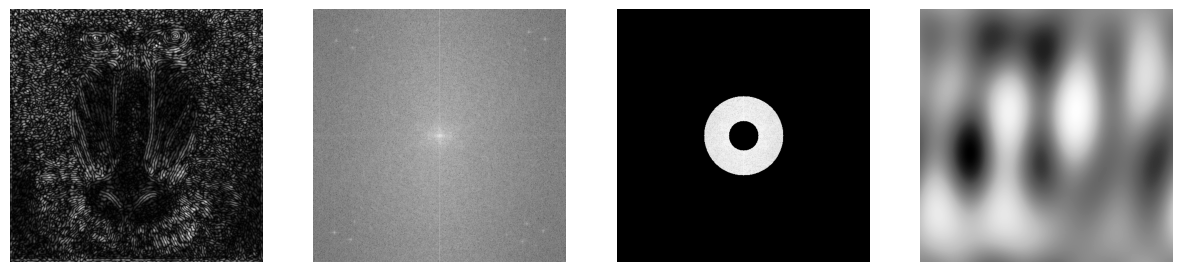

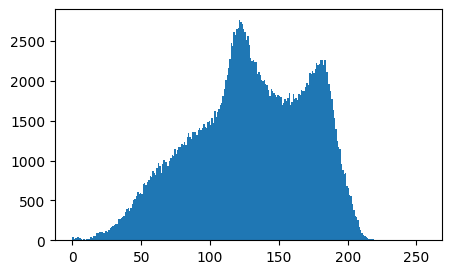

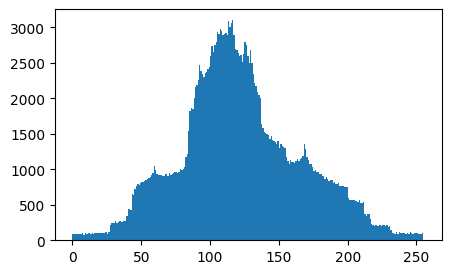

In [99]:
img_path = "images/baboon.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

r1=30; r2 = 80; high=False; reject=False; t=200
filtered, mag, core, back = apply_freq_filter3(img, r1, r2, high, reject, t)

fig, ax = plt.subplots(ncols=4, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[0].axis("off")
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
filter_type = "passa_alta" if high else "passa_baixa"
if r2 is not None: filter_type = "passa_faixa"
if r2 is not None and reject: filter_type = "rejeita_faixa"
radius = f"r1={r1}" if r2 is None else f"r1={r1}-r2={r2}"
file_path = f"{img_path.split('.png')[0]}-{filter_type}-{radius}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

ax[1].imshow(mag, cmap="Greys_r")
ax[1].axis("off")
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-espectro.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[2].imshow(core, cmap="Greys_r")
ax[2].axis("off")
extent = ax[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-núcleo-{filter_type}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[3].imshow(back, cmap="Greys_r")
ax[3].axis("off")
extent = ax[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-compressed-threshold={t}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

fig, ax = plt.subplots(figsize=(5,3))

hist_orig = ax.hist(img.ravel(), 256, [0,256])
# ax[0].title.set_text("Histograma imagem original.")
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_originalHistogram.png",
            bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))

hist_comp = ax.hist(back.ravel(), 256, [0,256])
# ax[1].title.set_text("Histograma imagem comprimida.")
# extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_compressedHistogram-threshold={t}.png",
            bbox_inches='tight')

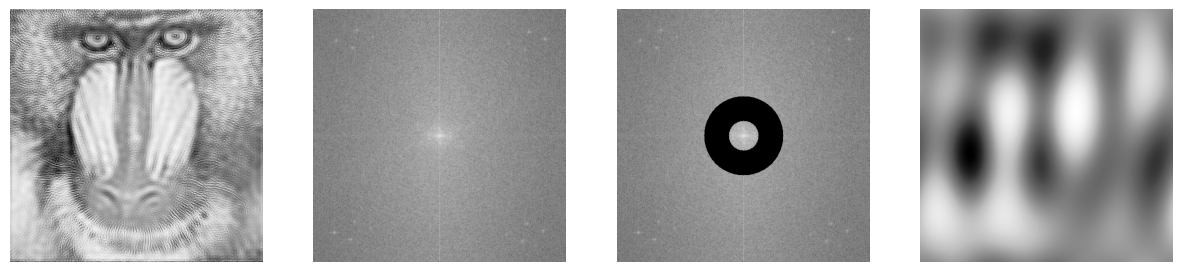

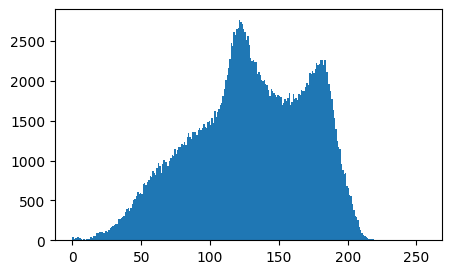

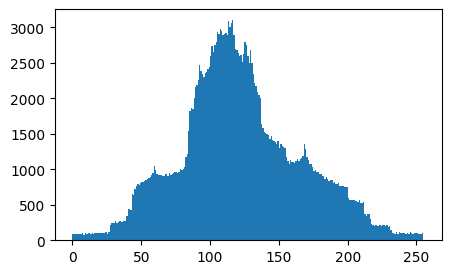

In [100]:
img_path = "images/baboon.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

r1=30; r2 = 80; high=False; reject=True; t=200
filtered, mag, core, back = apply_freq_filter3(img, r1, r2, high, reject, t)

fig, ax = plt.subplots(ncols=4, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[0].axis("off")
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
filter_type = "passa_alta" if high else "passa_baixa"
if r2 is not None: filter_type = "passa_faixa"
if r2 is not None and reject: filter_type = "rejeita_faixa"
radius = f"r1={r1}" if r2 is None else f"r1={r1}-r2={r2}"
file_path = f"{img_path.split('.png')[0]}-{filter_type}-{radius}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

ax[1].imshow(mag, cmap="Greys_r")
ax[1].axis("off")
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-espectro.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[2].imshow(core, cmap="Greys_r")
ax[2].axis("off")
extent = ax[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-núcleo-{filter_type}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[3].imshow(back, cmap="Greys_r")
ax[3].axis("off")
extent = ax[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-compressed-threshold={t}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

fig, ax = plt.subplots(figsize=(5,3))

hist_orig = ax.hist(img.ravel(), 256, [0,256])
# ax[0].title.set_text("Histograma imagem original.")
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_originalHistogram.png",
            bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))

hist_comp = ax.hist(back.ravel(), 256, [0,256])
# ax[1].title.set_text("Histograma imagem comprimida.")
# extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_compressedHistogram-threshold={t}.png",
            bbox_inches='tight')

## Imagem sintética

In [121]:
def get_gradient_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T

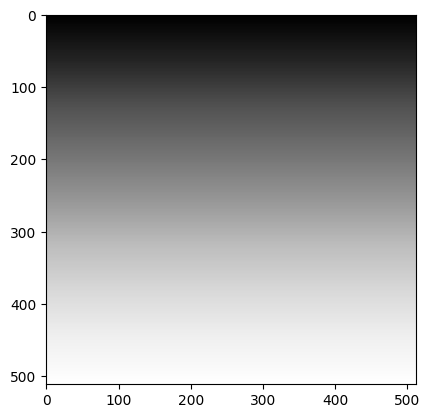

In [154]:
img = get_gradient_2d(0,255,512,512, False)
showimage(img)

In [157]:
img.shape

(512, 512)

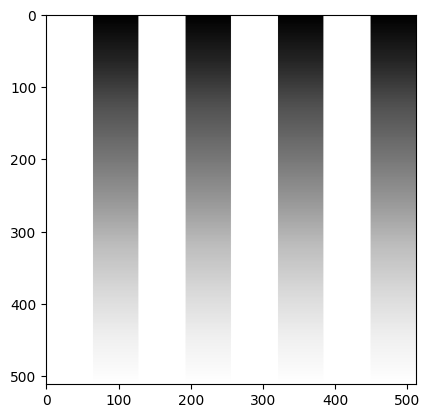

In [161]:
img = np.zeros((512,512))
img = get_gradient_2d(0,255,512,512, True)
img = cv2.transpose(img)
lins = np.arange(0, 512, 64)
draw=True
for x1, x2 in zip(lins, lins[1:]):
    if not draw:
        draw = not draw
        continue
    cv2.rectangle(img, (x1, 0), (x2, 512), (255,255,255), -1)
    draw = not draw
showimage(img)

/tmp/ipykernel_4370/1901625197.py:8: RuntimeWarning: divide by zero encountered in log
  magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
/tmp/ipykernel_4370/1901625197.py:42: RuntimeWarning: invalid value encountered in divide
  back_img = back_img*255 / back_img.max()
/tmp/ipykernel_4370/1901625197.py:43: RuntimeWarning: invalid value encountered in cast
  back_img = back_img.astype(np.uint8)


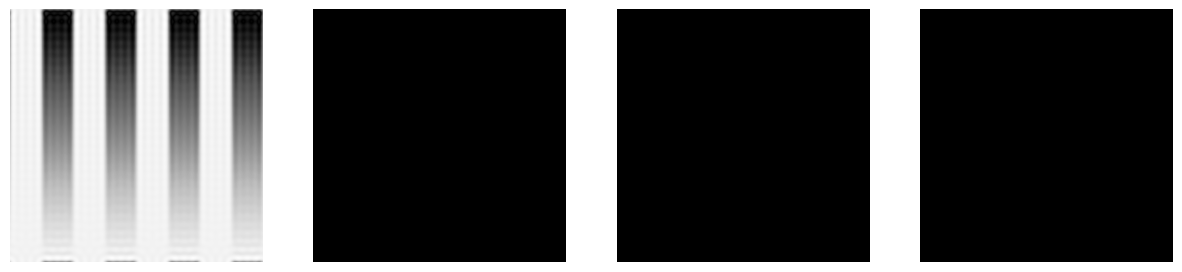

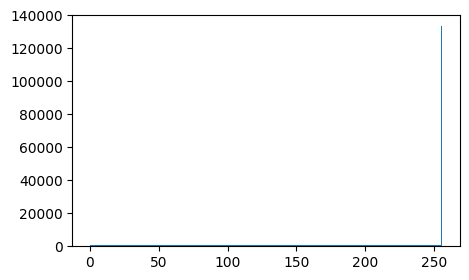

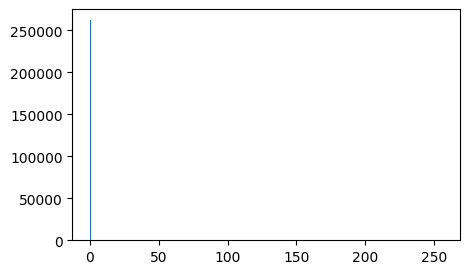

In [162]:
img_path = "images/diag1.png"
# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img = get_gradient_2d(0,255,512,512, True)

r1=30; r2 = None; high=False; reject=False; t=200
filtered, mag, core, back = apply_freq_filter3(img, r1, r2, high, reject, t)

fig, ax = plt.subplots(ncols=4, figsize=(15,5))
ax[0].imshow(filtered, cmap="Greys_r")
ax[0].axis("off")
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
filter_type = "passa_alta" if high else "passa_baixa"
if r2 is not None: filter_type = "passa_faixa"
if r2 is not None and reject: filter_type = "rejeita_faixa"
radius = f"r1={r1}" if r2 is None else f"r1={r1}-r2={r2}"
file_path = f"{img_path.split('.png')[0]}-{filter_type}-{radius}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

ax[1].imshow(mag, cmap="Greys_r")
ax[1].axis("off")
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-espectro.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[2].imshow(core, cmap="Greys_r")
ax[2].axis("off")
extent = ax[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-núcleo-{filter_type}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))


ax[3].imshow(back, cmap="Greys_r")
ax[3].axis("off")
extent = ax[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
file_path = f"{img_path.split('.png')[0]}-compressed-threshold={t}.png"
fig.savefig(file_path, bbox_inches=extent.expanded(1, .6))

fig, ax = plt.subplots(figsize=(5,3))

hist_orig = ax.hist(img.ravel(), 256, [0,256])
# ax[0].title.set_text("Histograma imagem original.")
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_originalHistogram.png",
            bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))

hist_comp = ax.hist(back.ravel(), 256, [0,256])
# ax[1].title.set_text("Histograma imagem comprimida.")
# extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"{img_path.split('.png')[0]}_compressedHistogram-threshold={t}.png",
            bbox_inches='tight')